In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'


In [ ]:
df = pd.read_csv('azure.csv',parse_dates=True,index_col='timestamp')
df.rename({'avg cpu': 'avg_cpu'}, axis=1,inplace=True)
df


,min cpu,max cpu,avg_cpu
timestamp,,,
2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06
...,...,...,...
2017-01-30 23:35:00,728008.315162,2.233166e+06,1.242129e+06
2017-01-30 23:40:00,737452.951022,2.219408e+06,1.235937e+06
2017-01-30 23:45:00,742153.686192,2.188120e+06,1.224276e+06


In [ ]:
df.head()

,min cpu,max cpu,avg_cpu
timestamp,,,
2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06


In [ ]:
df.describe

In [ ]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['avg_cpu'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['avg_cpu'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

In [ ]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [ ]:
df_testing = pd.DataFrame(np.log(df.avg_cpu).diff().diff(12))
adf_check(df_testing.avg_cpu.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -19.964607253245493
p-value : 0.0
Number of Lags Used : 37
Number of Observations Used : 8589
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='timestamp'>

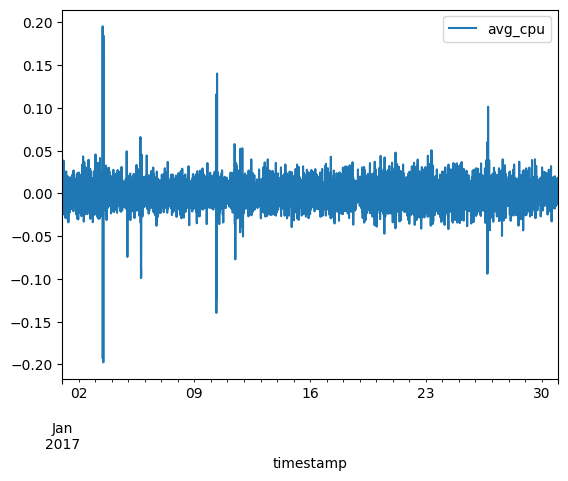

In [ ]:
# print(df_testing.to_string())
df_testing.plot()

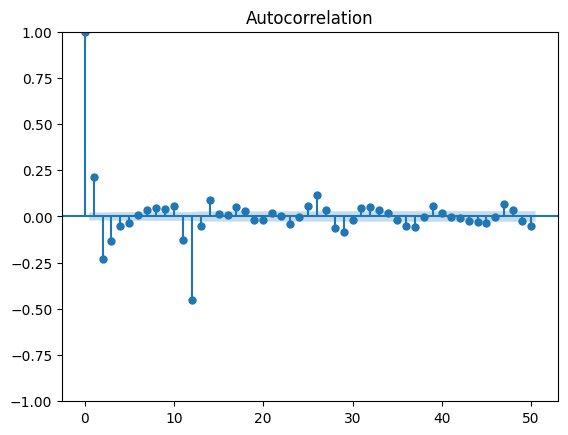

In [ ]:
ACF = plot_acf(df_testing.dropna(),lags=50)

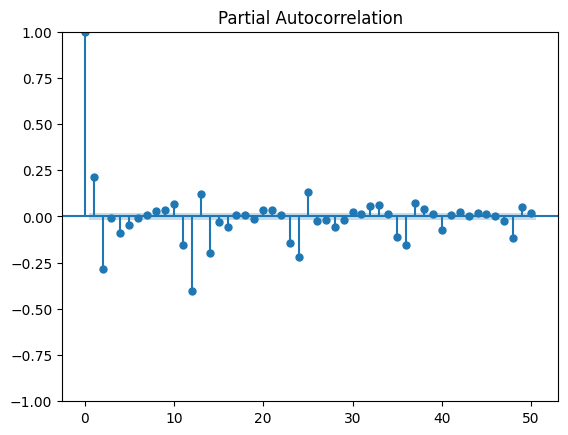

In [ ]:
PACF = plot_pacf(df_testing.dropna(),lags=50)

In [ ]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.avg_cpu))
  if(RMSE<best_RMSE):
    best_RMSE=RMSE
    best_p=i

The RMSE is : 0.01279144236340163 , Value of p :  1
The RMSE is : 0.012148856639978315 , Value of p :  2
The RMSE is : 0.012147511667264566 , Value of p :  3
The RMSE is : 0.012075091413109808 , Value of p :  4
The RMSE is : 0.01204540683925569 , Value of p :  5
The RMSE is : 0.012051563380116379 , Value of p :  6
The RMSE is : 0.012051645684537234 , Value of p :  7
The RMSE is : 0.01207040643802989 , Value of p :  8
The RMSE is : 0.012050871140685235 , Value of p :  9
The RMSE is : 0.011977269011688703 , Value of p :  10
The RMSE is : 0.01187320597443773 , Value of p :  11
The RMSE is : 0.010733761895855384 , Value of p :  12
The RMSE is : 0.010663799490398458 , Value of p :  13
The RMSE is : 0.010459566433007007 , Value of p :  14
The RMSE is : 0.0104545123139638 , Value of p :  15
The RMSE is : 0.010459942157983453 , Value of p :  16
The RMSE is : 0.010458819594643773 , Value of p :  17
The RMSE is : 0.010458358078783767 , Value of p :  18
The RMSE is : 0.010459019553013451 , Value 

In [ ]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.avg_cpu))

The RMSE is : 0.010445663573893413 , Value of p :  20


<Axes: xlabel='timestamp'>

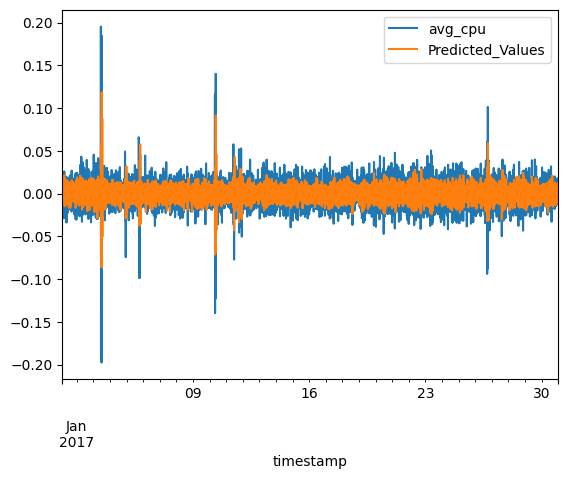

In [ ]:
df_c = pd.concat([df_train,df_test])
df_c[['avg_cpu','Predicted_Values']].plot()

In [ ]:
res = pd.DataFrame()
res['Residuals'] = df_c.avg_cpu - df_c.Predicted_Values

In [ ]:
res

,Residuals
timestamp,
2017-01-01 02:45:00,-0.016041
2017-01-01 02:50:00,0.001002
2017-01-01 02:55:00,0.002204
2017-01-01 03:00:00,0.003978
2017-01-01 03:05:00,0.002301
...,...
2017-01-30 23:35:00,-0.001011
2017-01-30 23:40:00,-0.000610
2017-01-30 23:45:00,0.003903


<Axes: ylabel='Density'>

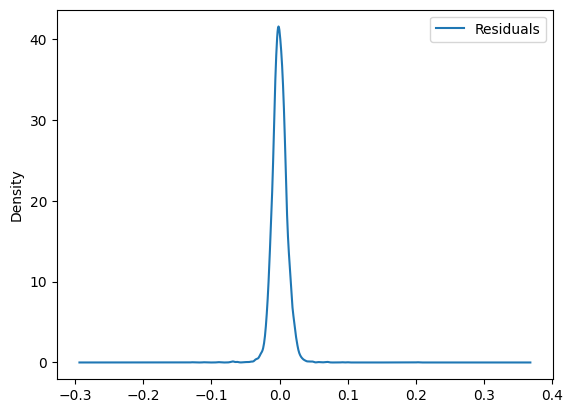

In [ ]:
res.plot(kind='kde')

The RMSE is : 0.010445863619387413 , Value of q :  1
The RMSE is : 0.01044584094031198 , Value of q :  2
The RMSE is : 0.010447426658685739 , Value of q :  3
The RMSE is : 0.010447278301223726 , Value of q :  4
The RMSE is : 0.010447009538361801 , Value of q :  5
The RMSE is : 0.010444048352153781 , Value of q :  6
The RMSE is : 0.010444670394569736 , Value of q :  7
The RMSE is : 0.010436586584938689 , Value of q :  8
The RMSE is : 0.01043422334336441 , Value of q :  9
The RMSE is : 0.010440690699127196 , Value of q :  10
The RMSE is : 0.010441868586298805 , Value of q :  11
The RMSE is : 0.010336638649652116 , Value of q :  12


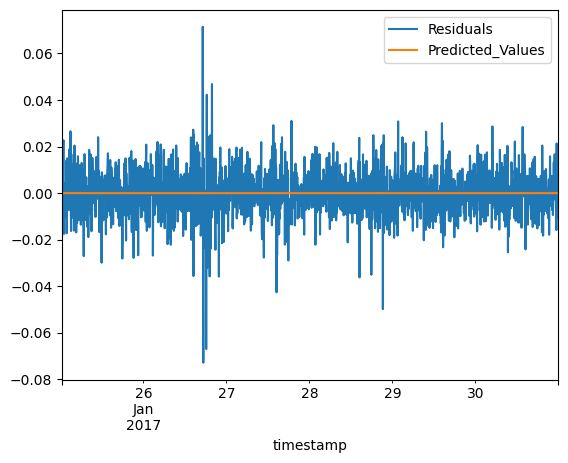

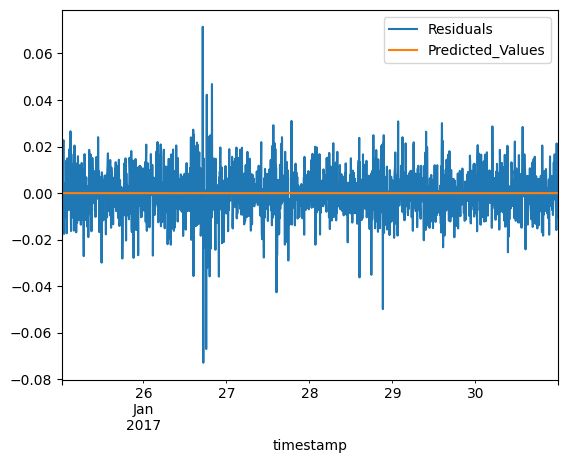

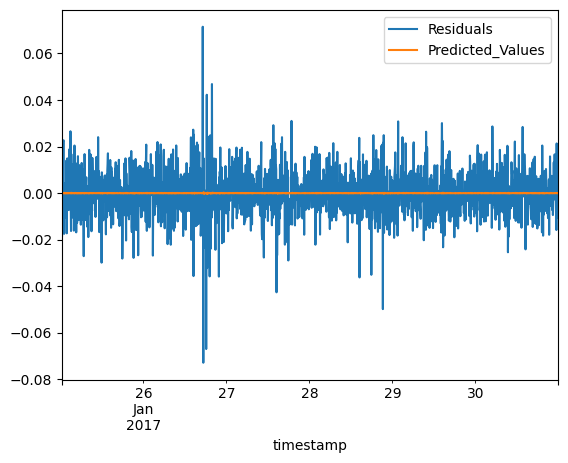

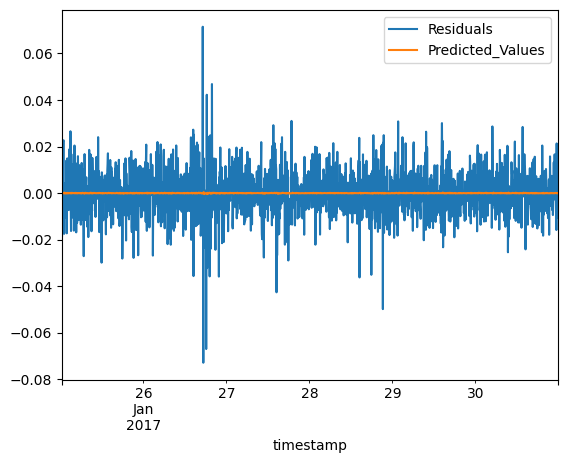

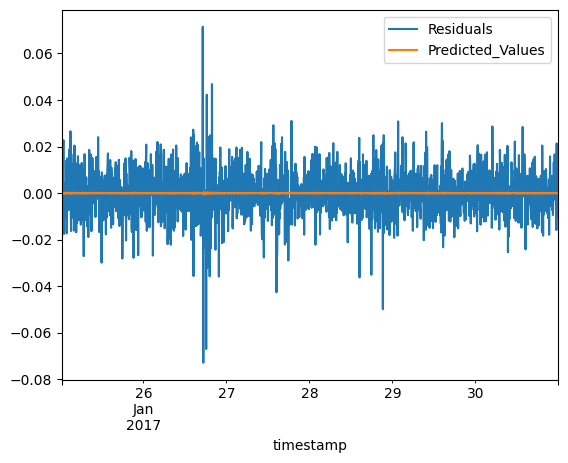

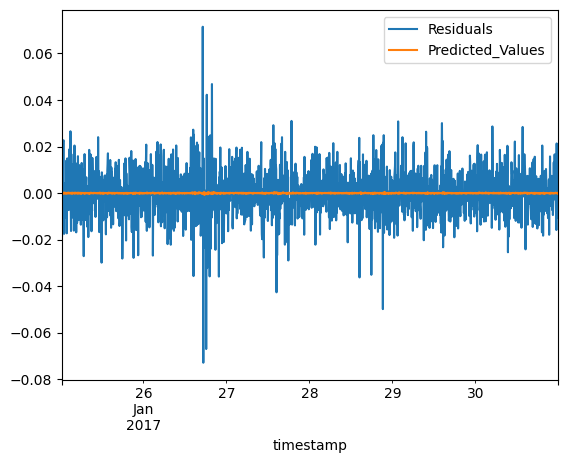

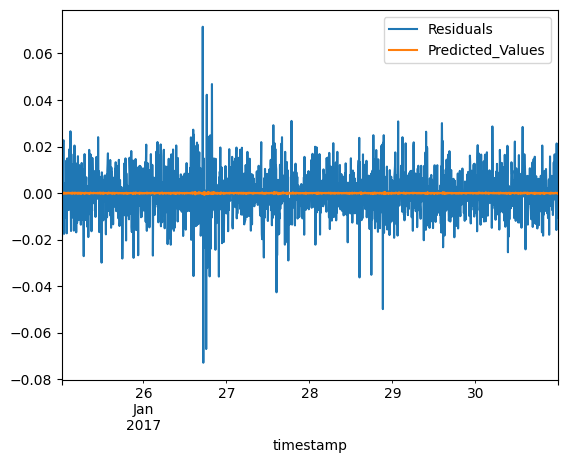

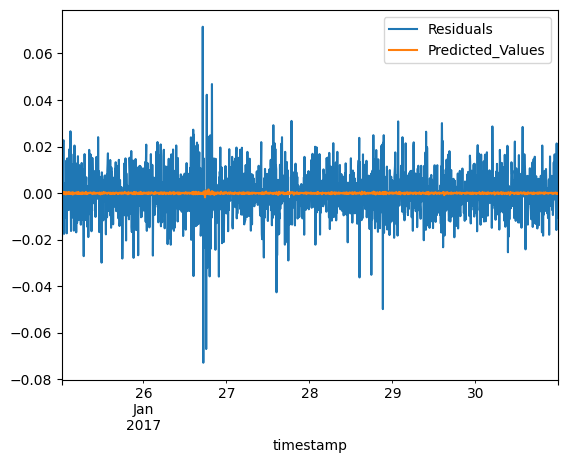

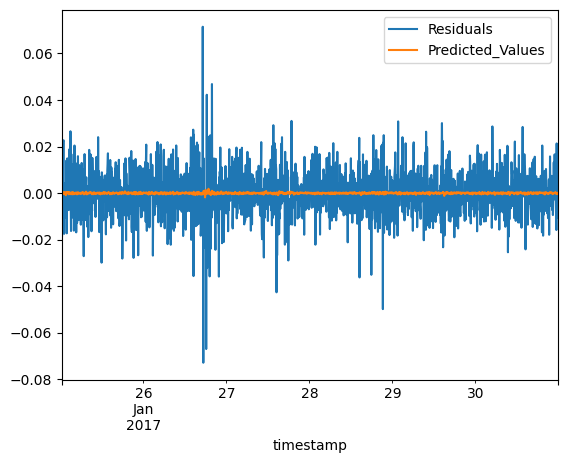

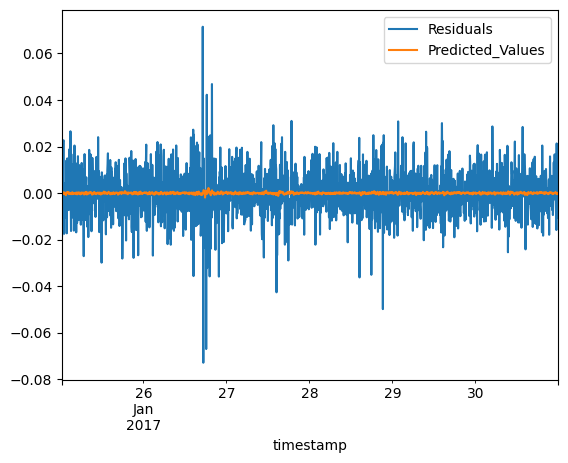

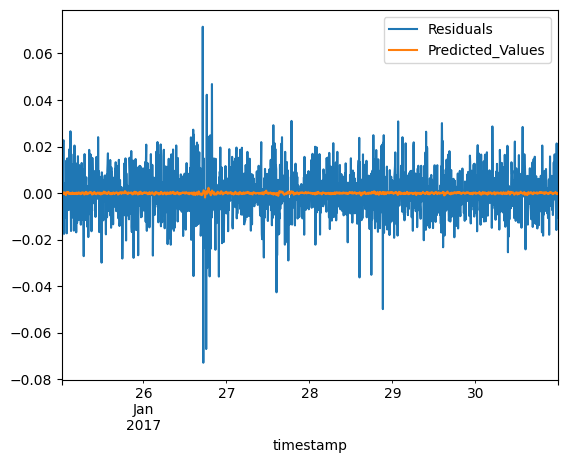

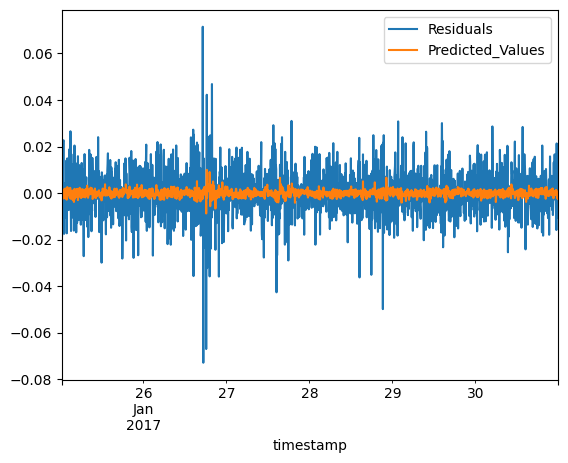

In [ ]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE=RMSE
    best_q=i

The RMSE is : 0.010336638649652116 , Value of q :  12
[[-0.00265079]
 [-0.00203641]
 [ 0.00259416]
 [ 0.00287037]
 [-0.00422634]
 [ 0.00814798]
 [-0.00312337]
 [-0.01699634]
 [-0.01587836]
 [-0.01418987]
 [-0.00558291]
 [-0.1349645 ]]
[4.97517584e-06]


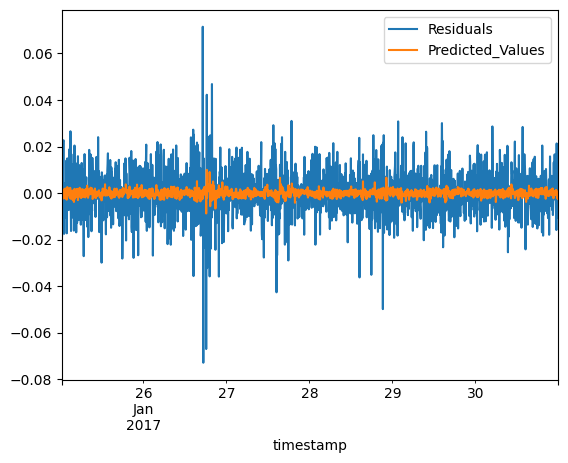

In [ ]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)


In [ ]:
res_c = pd.concat([res_train,res_test])

In [ ]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
timestamp,,,,,,,,,,,,,,
2017-01-01 03:45:00,0.007324,0.004560,0.004468,-0.018855,-0.014693,0.006146,0.008152,0.004923,0.002301,0.003978,0.002204,0.001002,-0.016041,0.001944
2017-01-01 03:50:00,0.002537,0.007324,0.004560,0.004468,-0.018855,-0.014693,0.006146,0.008152,0.004923,0.002301,0.003978,0.002204,0.001002,-0.000304
2017-01-01 03:55:00,0.011126,0.002537,0.007324,0.004560,0.004468,-0.018855,-0.014693,0.006146,0.008152,0.004923,0.002301,0.003978,0.002204,-0.000620
2017-01-01 04:00:00,-0.011903,0.011126,0.002537,0.007324,0.004560,0.004468,-0.018855,-0.014693,0.006146,0.008152,0.004923,0.002301,0.003978,-0.000978
2017-01-01 04:05:00,-0.003228,-0.011903,0.011126,0.002537,0.007324,0.004560,0.004468,-0.018855,-0.014693,0.006146,0.008152,0.004923,0.002301,-0.000184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-30 23:35:00,-0.001011,0.021343,-0.015840,0.001737,0.003722,0.001986,-0.002216,0.002180,0.016659,0.003328,-0.002731,0.013224,-0.000687,-0.000316
2017-01-30 23:40:00,-0.000610,-0.001011,0.021343,-0.015840,0.001737,0.003722,0.001986,-0.002216,0.002180,0.016659,0.003328,-0.002731,0.013224,-0.002183
2017-01-30 23:45:00,0.003903,-0.000610,-0.001011,0.021343,-0.015840,0.001737,0.003722,0.001986,-0.002216,0.002180,0.016659,0.003328,-0.002731,0.000152


from matplotlib import pyplot as plt
res_c['Residuals'].plot(kind='hist', bins=20, title='Residuals')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_c['Shifted_values_1'].plot(kind='hist', bins=20, title='Shifted_values_1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_c['Shifted_values_2'].plot(kind='hist', bins=20, title='Shifted_values_2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_c['Shifted_values_3'].plot(kind='hist', bins=20, title='Shifted_values_3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_c.plot(kind='scatter', x='Residuals', y='Shifted_values_1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_c.plot(kind='scatter', x='Shifted_values_1', y='Shifted_values_2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_c.plot(kind='scatter', x='Shifted_values_2', y='Shifted_values_3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_c.plot(kind='scatter', x='Shifted_values_3', y='Shifted_values_4', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
res_c['Residuals'].plot(kind='line', figsize=(8, 4), title='Residuals')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_c['Shifted_values_1'].plot(kind='line', figsize=(8, 4), title='Shifted_values_1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_c['Shifted_values_2'].plot(kind='line', figsize=(8, 4), title='Shifted_values_2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
res_c['Shifted_values_3'].plot(kind='line', figsize=(8, 4), title='Shifted_values_3')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df_c.Predicted_Values += res_c.Predicted_Values

<Axes: xlabel='timestamp'>

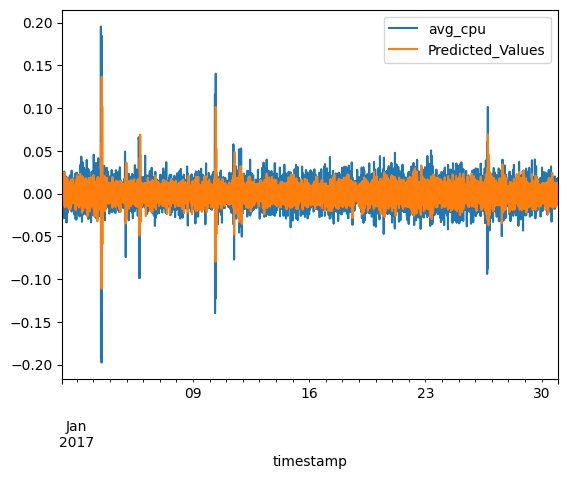

In [ ]:
df_c[['avg_cpu','Predicted_Values']].plot()

In [ ]:
df_c.avg_cpu += np.log(df).shift(1).avg_cpu
df_c.avg_cpu += np.log(df).diff().shift(5).avg_cpu
df_c.Predicted_Values += np.log(df).shift(1).avg_cpu
df_c.Predicted_Values += np.log(df).diff().shift(5).avg_cpu
df_c.avg_cpu = np.exp(df_c.avg_cpu)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)


,avg_cpu,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,...,Shifted_values_12,Shifted_values_13,Shifted_values_14,Shifted_values_15,Shifted_values_16,Shifted_values_17,Shifted_values_18,Shifted_values_19,Shifted_values_20,Predicted_Values
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 02:45:00,inf,0.013371,0.001511,-0.007857,0.010073,-0.012814,-0.024591,0.002762,0.038432,0.012177,...,-0.016321,-0.013713,0.015208,0.030694,-0.009278,0.001590,0.008902,-0.002550,-0.004368,NaN
2017-01-01 02:50:00,inf,-0.009028,0.013371,0.001511,-0.007857,0.010073,-0.012814,-0.024591,0.002762,0.038432,...,-0.004025,-0.016321,-0.013713,0.015208,0.030694,-0.009278,0.001590,0.008902,-0.002550,NaN
2017-01-01 02:55:00,inf,-0.006592,-0.009028,0.013371,0.001511,-0.007857,0.010073,-0.012814,-0.024591,0.002762,...,-0.010603,-0.004025,-0.016321,-0.013713,0.015208,0.030694,-0.009278,0.001590,0.008902,NaN
2017-01-01 03:00:00,inf,0.008610,-0.006592,-0.009028,0.013371,0.001511,-0.007857,0.010073,-0.012814,-0.024591,...,0.012177,-0.010603,-0.004025,-0.016321,-0.013713,0.015208,0.030694,-0.009278,0.001590,NaN
2017-01-01 03:05:00,inf,0.001928,0.008610,-0.006592,-0.009028,0.013371,0.001511,-0.007857,0.010073,-0.012814,...,0.038432,0.012177,-0.010603,-0.004025,-0.016321,-0.013713,0.015208,0.030694,-0.009278,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-30 23:35:00,inf,0.018188,-0.010882,0.003615,0.006665,-0.005344,-0.003574,0.003444,0.011242,0.001145,...,-0.006266,-0.007323,-0.009328,-0.000331,-0.004658,0.006945,-0.005351,0.006149,0.008151,inf
2017-01-30 23:40:00,inf,0.011676,0.018188,-0.010882,0.003615,0.006665,-0.005344,-0.003574,0.003444,0.011242,...,0.012310,-0.006266,-0.007323,-0.009328,-0.000331,-0.004658,0.006945,-0.005351,0.006149,inf
2017-01-30 23:45:00,inf,-0.009189,0.011676,0.018188,-0.010882,0.003615,0.006665,-0.005344,-0.003574,0.003444,...,0.003289,0.012310,-0.006266,-0.007323,-0.009328,-0.000331,-0.004658,0.006945,-0.005351,inf
